In [231]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import os
from tensorflow.keras.models import load_model
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import confusion_matrix, classification_report

In [16]:
# load all models by fold

model_dict = {}

for i in range(1,11):
    model_dict[i] = load_model('models/mels_basic_cnn_fold{}.hdf5'.format(i))

In [4]:
labels = np.array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [17]:
#load data for splitting by test

vec_type = 'mels'
data_path = os.path.join('pickles', 'urbansound_'+ vec_type + '.p')

with open(data_path, 'rb') as handle:
    data = pickle.load(handle)

X, y, folds = data[0], data[1], data[2]

X = X.reshape(X.shape[0], 60, 174, 1)

In [42]:
# build dataframe to store predictions for each fold, for each sample 
# not all samples will have fold
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [160]:
meta = metadata.drop(columns=['fsID', 'start', 'end', 'salience'])
meta

,slice_file_name,fold,classID,class
0,100032-3-0-0.wav,5,3,dog_bark
1,100263-2-0-117.wav,5,2,children_playing
2,100263-2-0-121.wav,5,2,children_playing
3,100263-2-0-126.wav,5,2,children_playing
4,100263-2-0-137.wav,5,2,children_playing
...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn
8728,99812-1-3-0.wav,7,1,car_horn
8729,99812-1-4-0.wav,7,1,car_horn
8730,99812-1-5-0.wav,7,1,car_horn


Important Note: classID relates to how 'y' was encoded

In [158]:
meta.classID.unique()

array([3, 2, 1, 0, 9, 6, 8, 5, 7, 4])

In [161]:
y_df = pd.DataFrame(y)
y_df

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8727,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8728,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8729,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
all_preds = np.zeros((8732, 10))

In [148]:
logo = LeaveOneGroupOut()
#recreate fold indices used to train and test models. Use preds on test set 



for train_idx, test_idx in logo.split(X, y, folds):
    
    _, X_test, _, y_test = X[train_idx], X[test_idx], y[train_idx], y[test_idx]
    fold = folds[test_idx][0]
    
    #load model
    model = model_dict[fold]
    
    
    #make preds
    #each sample should have a 10 dimensional pred
    fold_pred = model.predict_proba(X_test)
    print('fold pred shape: ', fold_pred.shape)
    
    #stack preds on earlier samples
    all_preds[test_idx, :] = fold_pred
#     print("samples_preds shape: ", samples_preds.shape)
    


fold pred shape:  (873, 10)
fold pred shape:  (888, 10)
fold pred shape:  (925, 10)
fold pred shape:  (990, 10)
fold pred shape:  (936, 10)
fold pred shape:  (823, 10)
fold pred shape:  (838, 10)
fold pred shape:  (806, 10)
fold pred shape:  (816, 10)
fold pred shape:  (837, 10)


In [165]:
pred_classes = np.argmax(all_preds, axis=1)
pred_classes.shape

(8732,)

In [167]:
meta['pred_classes'] = pred_classes
meta

,slice_file_name,fold,classID,class,pred_classes
0,100032-3-0-0.wav,5,3,dog_bark,3
1,100263-2-0-117.wav,5,2,children_playing,9
2,100263-2-0-121.wav,5,2,children_playing,2
3,100263-2-0-126.wav,5,2,children_playing,2
4,100263-2-0-137.wav,5,2,children_playing,2
...,...,...,...,...,...
8727,99812-1-2-0.wav,7,1,car_horn,7
8728,99812-1-3-0.wav,7,1,car_horn,7
8729,99812-1-4-0.wav,7,1,car_horn,7
8730,99812-1-5-0.wav,7,1,car_horn,7


In [182]:
target_names = []
for i in range(10):
    target_names.append(meta[meta['classID'] == i]['class'].iloc[0])
print(target_names)

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [217]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontweight='bold')
    plt.colorbar(fraction=.04)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [226]:
cm =confusion_matrix(meta.classID, meta.pred_classes)
# np.set_printoptions(precision=2)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure(figsize=(10, 10))
# plot_confusion_matrix(cm)


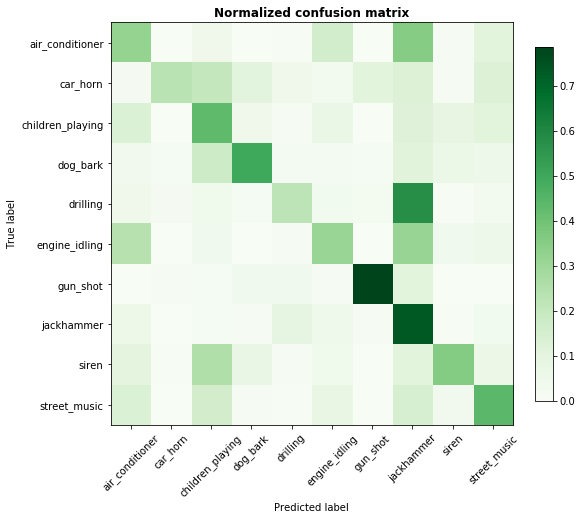

In [248]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix', cmap='Greens')


In [233]:
print(classification_report(meta.classID, meta.pred_classes))

              precision    recall  f1-score   support

           0       0.31      0.32      0.31      1000
           1       0.69      0.23      0.35       429
           2       0.35      0.43      0.39      1000
           3       0.71      0.50      0.58      1000
           4       0.54      0.22      0.32      1000
           5       0.40      0.31      0.35      1000
           6       0.76      0.79      0.77       374
           7       0.29      0.74      0.42      1000
           8       0.57      0.36      0.44       929
           9       0.48      0.44      0.46      1000

    accuracy                           0.42      8732
   macro avg       0.51      0.43      0.44      8732
weighted avg       0.48      0.42      0.42      8732



In [250]:
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'Conv2D',
   'config': {'name': 'conv2d',
    'trainable': True,
    'batch_input_shape': (None, 60, 174, 1),
    'dtype': 'float32',
    'filters': 16,
    'kernel_size': (3, 3),
    'strides': (1, 1),
    'padding': 'same',
    'data_format': 'channels_last',
    'dilation_rate': (1, 1),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': {'class_name': 'L1L2',
     'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}},
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'MaxPooling2D',
   'config': {'name': 'max_pooling2d',
    'trainable': True,
    'dtype': 'float32',
    'pool_size': (2, 2),
    'padding': 'valid',
    'strides': (2, 2),
    'data_format': 'channels_last'